In [10]:
# eec266_project.ipynb
# Author: Mason del Rosario
# Replicate numerical results from 2010 paper, "Maximum Mutual Information Design for MIMO Systems With Imperfect Channel Knowledge" (Ding, Blostein)
import numpy as np
from scipy.linalg import sqrtm
import functools as ft
import time

# subclass ndarray to include Hermitian
class complex_array(np.ndarray):
    @property
    def H(self):
        return self.conj().T

In [2]:
# parameters for system model
n_T = 4 # transmitter antennas
n_R = 4 # receiver antennas
rho_T = 0.9 # correlation constant for R_T
rho_R = 0.5 # correlation constant for R_R
var_E = 0.01 # error variance
var_n = 0.01 # noise variance

In [3]:
# core function: iterative solver for MMSE precoder/decoder pair yielding opt. covariance matrix for Capacity Lower Bound
def precoder_solver(Hhat,R_T,R_R,P_T,eps=0.01):
    # Step 1: F initialized as scaled version of the identity.
    r_g = np.linalg.matrix_rank(Hhat)
    F = np.sqrt(P_T)/r_g*np.eye(r_g).view(complex_array)
    MSE_iter = 10
    i = 0
    while (MSE_iter > eps):
        Q = np.matmul(F,F.H)
        # step 2: update Rn_total, G (decoder)
        Rn_total = total_noise(R_T,R_R,var_E,Q,var_n)
        G = decoder(F,Hhat,Rn_total)
        # step 3: update lagrangian multipliers, mu and alpha
        mu_g = mu(var_n,P_T,G,Rn_total,Hhat,F)
        alpha_g = alpha(G,R_R,Rn_total,Hhat,F)
        # step 4: update F (precoder)
        F_n = precoder(mu_g,alpha_g,var_E,R_T,Hhat,G,P_T)
        MSE_iter = np.linalg.norm(F_n-F) # numpy norm is Frob norm by default
        F = F_n
        i=i+1
      #    if i % 2 ==0:
      #        print('Iteration #{}'.format(i))
#     print("Q: \n{}".format(Q))
#     print("Rn_total:\n{}".format(Rn_total))
#     print("G: \n{}".format(G))
#     print("mu: \n{}".format(mu_g))
#     print("alpha: \n{}".format(alpha_g))
#     print("F_n: \n{}".format(F_n))
#     print('P_T: {}'.format(P_T))
#     print('tr(FF^H): {}'.format(np.trace(np.matmul(F_n,F_n.H))))
    return F, Rn_total

# helper function: update total noise (2)
def total_noise(R_T,R_R,var_E,Q,var_n):
    n_R = np.shape(R_T)[0]
    return var_E*np.trace(np.matmul(R_T,Q))*R_R+var_n*np.eye(n_R,dtype=complex)

# helper function: update decoder, G (29/Step 2 in Table 1)
def decoder(F,Hhat,Rn_total):
    g1 = np.matmul(F.H,Hhat.H)
    g2 = np.linalg.inv(ft.reduce(np.matmul,[Hhat,F,F.H,Hhat.H])+Rn_total)
    return np.matmul(g1,g2)

# helper function: update lagrangian multiplier, mu (37)
def mu(var_n,P_T,G,Rn_total,Hhat,F):
    temp = ft.reduce(np.matmul,[G,np.linalg.inv(Rn_total),Hhat,F])
    return var_n/P_T*np.trace(temp)

# helper function: update lagrangian multiplier, alpha (33)
def alpha(G,R_R,Rn_total,Hhat,F):
    temp = ft.reduce(np.matmul,[G,R_R,np.linalg.inv(Rn_total),Hhat,F])
    return np.trace(temp)

# helper function: update precoder, F (34/Step 4 in Table 1)
def precoder(mu_g,alpha_g,var_E,R_T,Hhat,G,P_T):
    n_T = R_T.shape[0]
    temp = np.linalg.inv(mu_g*np.eye(n_T)+alpha_g*var_E*R_T)
    F = ft.reduce(np.matmul,[temp,Hhat.H,G.H])
    # scale s.t. tr(F*F.H)=P_T
    F_scale = np.sqrt(P_T/np.trace(np.matmul(F,F.H)))
    return F_scale*F

# core function: circularly symmetric complex normal distribution
def circ_complex_normal(m, n, mean=None, cov=None):
    if type(mean)==type(None):
        mean = np.zeros(2)
    if type(cov)==type(None):
        cov = np.eye(2)
    # generate i.i.d complex samples
    samp = np.random.multivariate_normal(mean, cov, (m,n))
    # turn into complex numbers
    out = np.zeros((m,n),dtype=complex)
    for i in range(m):
        for j in range(n):
            temp = samp[i,j]
            out[i,j] = temp[0] + 1j*temp[1]
    return out

# core function: exponential correlation model from Aalto, 1995
def exponential_corr(n, rho):
    # inputs:
    # -> n = # of antennas
    # -> rho = correlation constant for exponential correlation model
    R = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            R[i,j] = rho**(np.abs(i-j))
    R = symmetrize(R)
    return R

# helper function: symmetrize
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [55]:
# helper function: exponential correlation matrices
def corr_matrices(n_T,n_R,rho_T,rho_R):
    R_T = exponential_corr(n_T,rho_T)
    R_R = exponential_corr(n_R,rho_R)
    return R_T, R_R

# helper function: channel realization; generate CSI and CSI estimate
def channel_realization(n_T,n_R,R_T,R_R,var_E,var_n,scale=1.0):
    # i.i.d. circularly symmetric complex normal matrices for system model
    H_w = circ_complex_normal(n_T,n_R).view(complex_array) # csi estimate sampled using unit covariance matrix
    Hhat_cov = scale*(1-var_E)*np.eye(2) # csi estimate covariance matrix
    Hhat_w = circ_complex_normal(n_T,n_R,cov=Hhat_cov).view(complex_array)
    E_cov = scale*(var_E)*np.eye(2) # estimation covariance matrix
    E_w = circ_complex_normal(n_T,n_R,cov=E_cov).view(complex_array)
    # print('H_w:\n{}'.format(H_w))
    # print('Hhat_w:\n{}'.format(Hhat_w))
    # print('E_w:\n{}'.format(E_w))
    # H from correlation matrices and H_w
    H = sqrtm(R_R)*H_w*sqrtm(R_T)
    Hhat = sqrtm(R_R)*Hhat_w*sqrtm(R_T)
    # print('H:\n{}'.format(H))
    # print('Hhat:\n{}'.format(Hhat))

    # generate white Gaussian noise vector
    var_n = 0.01
    cov_n = scale*var_n*np.eye(2)
    n = circ_complex_normal(1,n_R,cov=cov_n)# noise vector
    # print('n:\n{}'.format(n))
    return H,Hhat

R_T, R_R = corr_matrices(n_T,n_R,rho_T,rho_R)
H,Hhat = channel_realization(n_T,n_R,R_T,R_R,var_E,var_n)

In [5]:
# helper function: mutual information for MIMO channel capacity Lower Bound
def mutual_info_LB(n_R,Hhat,F,Rn_total):
    # mutual information as defined in (3) from the paper
    # assume we have optimal precoder to calculate optimal Q
    Q = np.matmul(F,F.H)
    temp = np.eye(n_R)+ft.reduce(np.matmul,[Hhat,Q,Hhat.H,np.linalg.inv(Rn_total)])
    return np.log2(np.linalg.det(temp))

In [57]:
# iterate through channel realizations to get capacity lower bound
def get_capacity_LB(var_n,P_T,n_T,n_R,rho_T,rho_R,var_E=0.01,samples=500,div=100):
    MI_samples = []
    for k in range(samples):
        if div != 0 and k % div == 0:
            print('-> iteration #{}'.format(k))
        P_T = 1
        R_T, R_R = corr_matrices(n_T,n_R,rho_T,rho_R)
        H,Hhat = channel_realization(n_T,n_R,R_T,R_R,var_E,var_n)
        F, Rn_total = precoder_solver(Hhat,R_T,R_R,P_T)
        MI = mutual_info_LB(n_R,Hhat,F,Rn_total)
        MI_samples.append(MI)
    C_low = np.mean(MI_samples)
    return C_low

In [49]:
# timer class for tracking/projecting iteration finishing time
# adapted from Eli Bendersky's stackoverflow answer to "what is the python equivalent of matlabs tic and toc functions"
class Timer(object):
    def __init__(self,name=None,target=8):
        self.name = name
        self.finished = 0
        self.times = []
        self.target = target
    
    def __enter__(self):
        self.tstart = time.time()
    
    def __exit__(self, type, value, traceback):
        self.finished = self.finished + 1
        self.elapsed = time.time() - self.tstart
        self.times.append(self.elapsed)
        self.avg_time = np.mean(self.times)
        self.projected_time = (self.target - self.finished)*self.avg_time
        print('--- {}-> Time Elapsed: {:2.2f} minutes - ETA: {:2.2f} minutes for {} cases ---'.format(self.name,np.sum(self.times)/60,self.projected_time/60,self.target-self.finished))
    
    def get_times(self):
        return self.times

In [48]:
# test timing estimator
N = int(1e4)
m = 2
n = 2
target = 8
timer = Timer("Test",target=target)

for j in range(target):
    with timer:
        for i in range(N):
            test = circ_complex_normal(m, n)
            
print(timer.get_times()) # times in seconds

--- Test-> Time Elapsed: 0.05 minutes - ETA: 0.38 minutes for 7 cases---
--- Test-> Time Elapsed: 0.11 minutes - ETA: 0.32 minutes for 6 cases---
--- Test-> Time Elapsed: 0.16 minutes - ETA: 0.26 minutes for 5 cases---
--- Test-> Time Elapsed: 0.21 minutes - ETA: 0.21 minutes for 4 cases---
--- Test-> Time Elapsed: 0.26 minutes - ETA: 0.16 minutes for 3 cases---
--- Test-> Time Elapsed: 0.31 minutes - ETA: 0.10 minutes for 2 cases---
--- Test-> Time Elapsed: 0.37 minutes - ETA: 0.05 minutes for 1 cases---
--- Test-> Time Elapsed: 0.42 minutes - ETA: 0.00 minutes for 0 cases---
[3.2739593982696533, 3.101597785949707, 3.092790365219116, 3.0626232624053955, 3.101919651031494, 3.115661144256592, 3.291674852371216, 3.224848747253418]


In [58]:
P_T = 1
# dicts with [rho_T,rho_R] values for exponential correlation
fig3_cases = {
    0: [0.0,0.0],
    1: [0.5,0.0],
    2: [0.5,0.5],
    3: [0.9,0.0]
}
fig4_cases = {
    0: [0.5,0.0],
    1: [0.0,0.5],
    2: [0.9,0.0],
    3: [0.0,0.9]
}

fig_cases = [fig3_cases, fig4_cases]
snr_list = [x for x in range(0,40,4)]
cap_out_list = []
time_list = []
num_done = 0
target = 8
timer = Timer("Outer Timer",target=target)
for k in range(len(fig_cases)):
    fig_case = fig_cases[k]
    cap_dict = {0:[],1:[],2:[],3:[]}
    for l in range(4):
        with timer:
            cap_list = []
            rho_T,rho_R = fig_case[l]
            timer_in = Timer("Inner Timer",target=len(snr_list))
            for snr in snr_list:
                with timer_in:
                    print('rho_T={},rho_R={}, snr={}'.format(rho_T,rho_R,snr))
                    var_n = P_T / (10**(snr/10))
                    print('var_n: {}'.format(var_n))
                    cap = get_capacity_LB(var_n,P_T,n_T,n_R,rho_T,rho_R)
                    print('capacity: {}'.format(cap))
                    cap_list.append(cap)
            cap_dict[l] = cap_list
    cap_out_list.append(cap_dict)

all_times = timer.get_times()

rho_T=0.0,rho_R=0.0, snr=0
var_n: 1.0
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (2.620876020470475-3.2662145574076493e-18j)
--- Inner Timer-> Time Elapsed: 0.13 minutes - ETA: 1.17 minutes for 9 cases ---
rho_T=0.0,rho_R=0.0, snr=4
var_n: 0.39810717055349726
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (4.482029287533724+2.359185518410385e-18j)
--- Inner Timer-> Time Elapsed: 0.26 minutes - ETA: 1.04 minutes for 8 cases ---
rho_T=0.0,rho_R=0.0, snr=8
var_n: 0.15848931924611132
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (7.108829094516969+1.3672327770812553e-18j)
--- Inner Timer-> Time Elapsed: 0.43 minutes - ETA: 1.01 minutes for 7 cases ---
rho_T=0.0,rho_R=0.0, snr=12
var_n: 0.06309573444801933
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (10.104053780508922+2.78073048080

-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (20.669488147219376+5.0472190051671576e-17j)
--- Inner Timer-> Time Elapsed: 7.79 minutes - ETA: 0.00 minutes for 0 cases ---
--- Outer Timer-> Time Elapsed: 16.79 minutes - ETA: 27.99 minutes for 5 cases ---
rho_T=0.9,rho_R=0.0, snr=0
var_n: 1.0
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (1.8037675186481863-1.4097449232177461e-18j)
--- Inner Timer-> Time Elapsed: 0.14 minutes - ETA: 1.24 minutes for 9 cases ---
rho_T=0.9,rho_R=0.0, snr=4
var_n: 0.39810717055349726
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (3.1737218717347933-2.5451794610097433e-18j)
--- Inner Timer-> Time Elapsed: 0.26 minutes - ETA: 1.04 minutes for 8 cases ---
rho_T=0.9,rho_R=0.0, snr=8
var_n: 0.15848931924611132
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (5.35433269052601

-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (20.120848506530326-3.069891394838105e-20j)
--- Inner Timer-> Time Elapsed: 0.80 minutes - ETA: 0.09 minutes for 1 cases ---
rho_T=0.0,rho_R=0.5, snr=36
var_n: 0.00025118864315095795
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (20.246941676016537-1.5887098338808879e-18j)
--- Inner Timer-> Time Elapsed: 0.89 minutes - ETA: 0.00 minutes for 0 cases ---
--- Outer Timer-> Time Elapsed: 28.44 minutes - ETA: 9.48 minutes for 2 cases ---
rho_T=0.9,rho_R=0.0, snr=0
var_n: 1.0
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (1.730401277848804+2.889905190054092e-19j)
--- Inner Timer-> Time Elapsed: 0.05 minutes - ETA: 0.46 minutes for 9 cases ---
rho_T=0.9,rho_R=0.0, snr=4
var_n: 0.39810717055349726
-> iteration #0
-> iteration #100
-> iteration #200
-> iteration #300
-> iteration #400
capacity: (3.15430465605066

In [ ]:
# save data for export
pickle.dump()

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


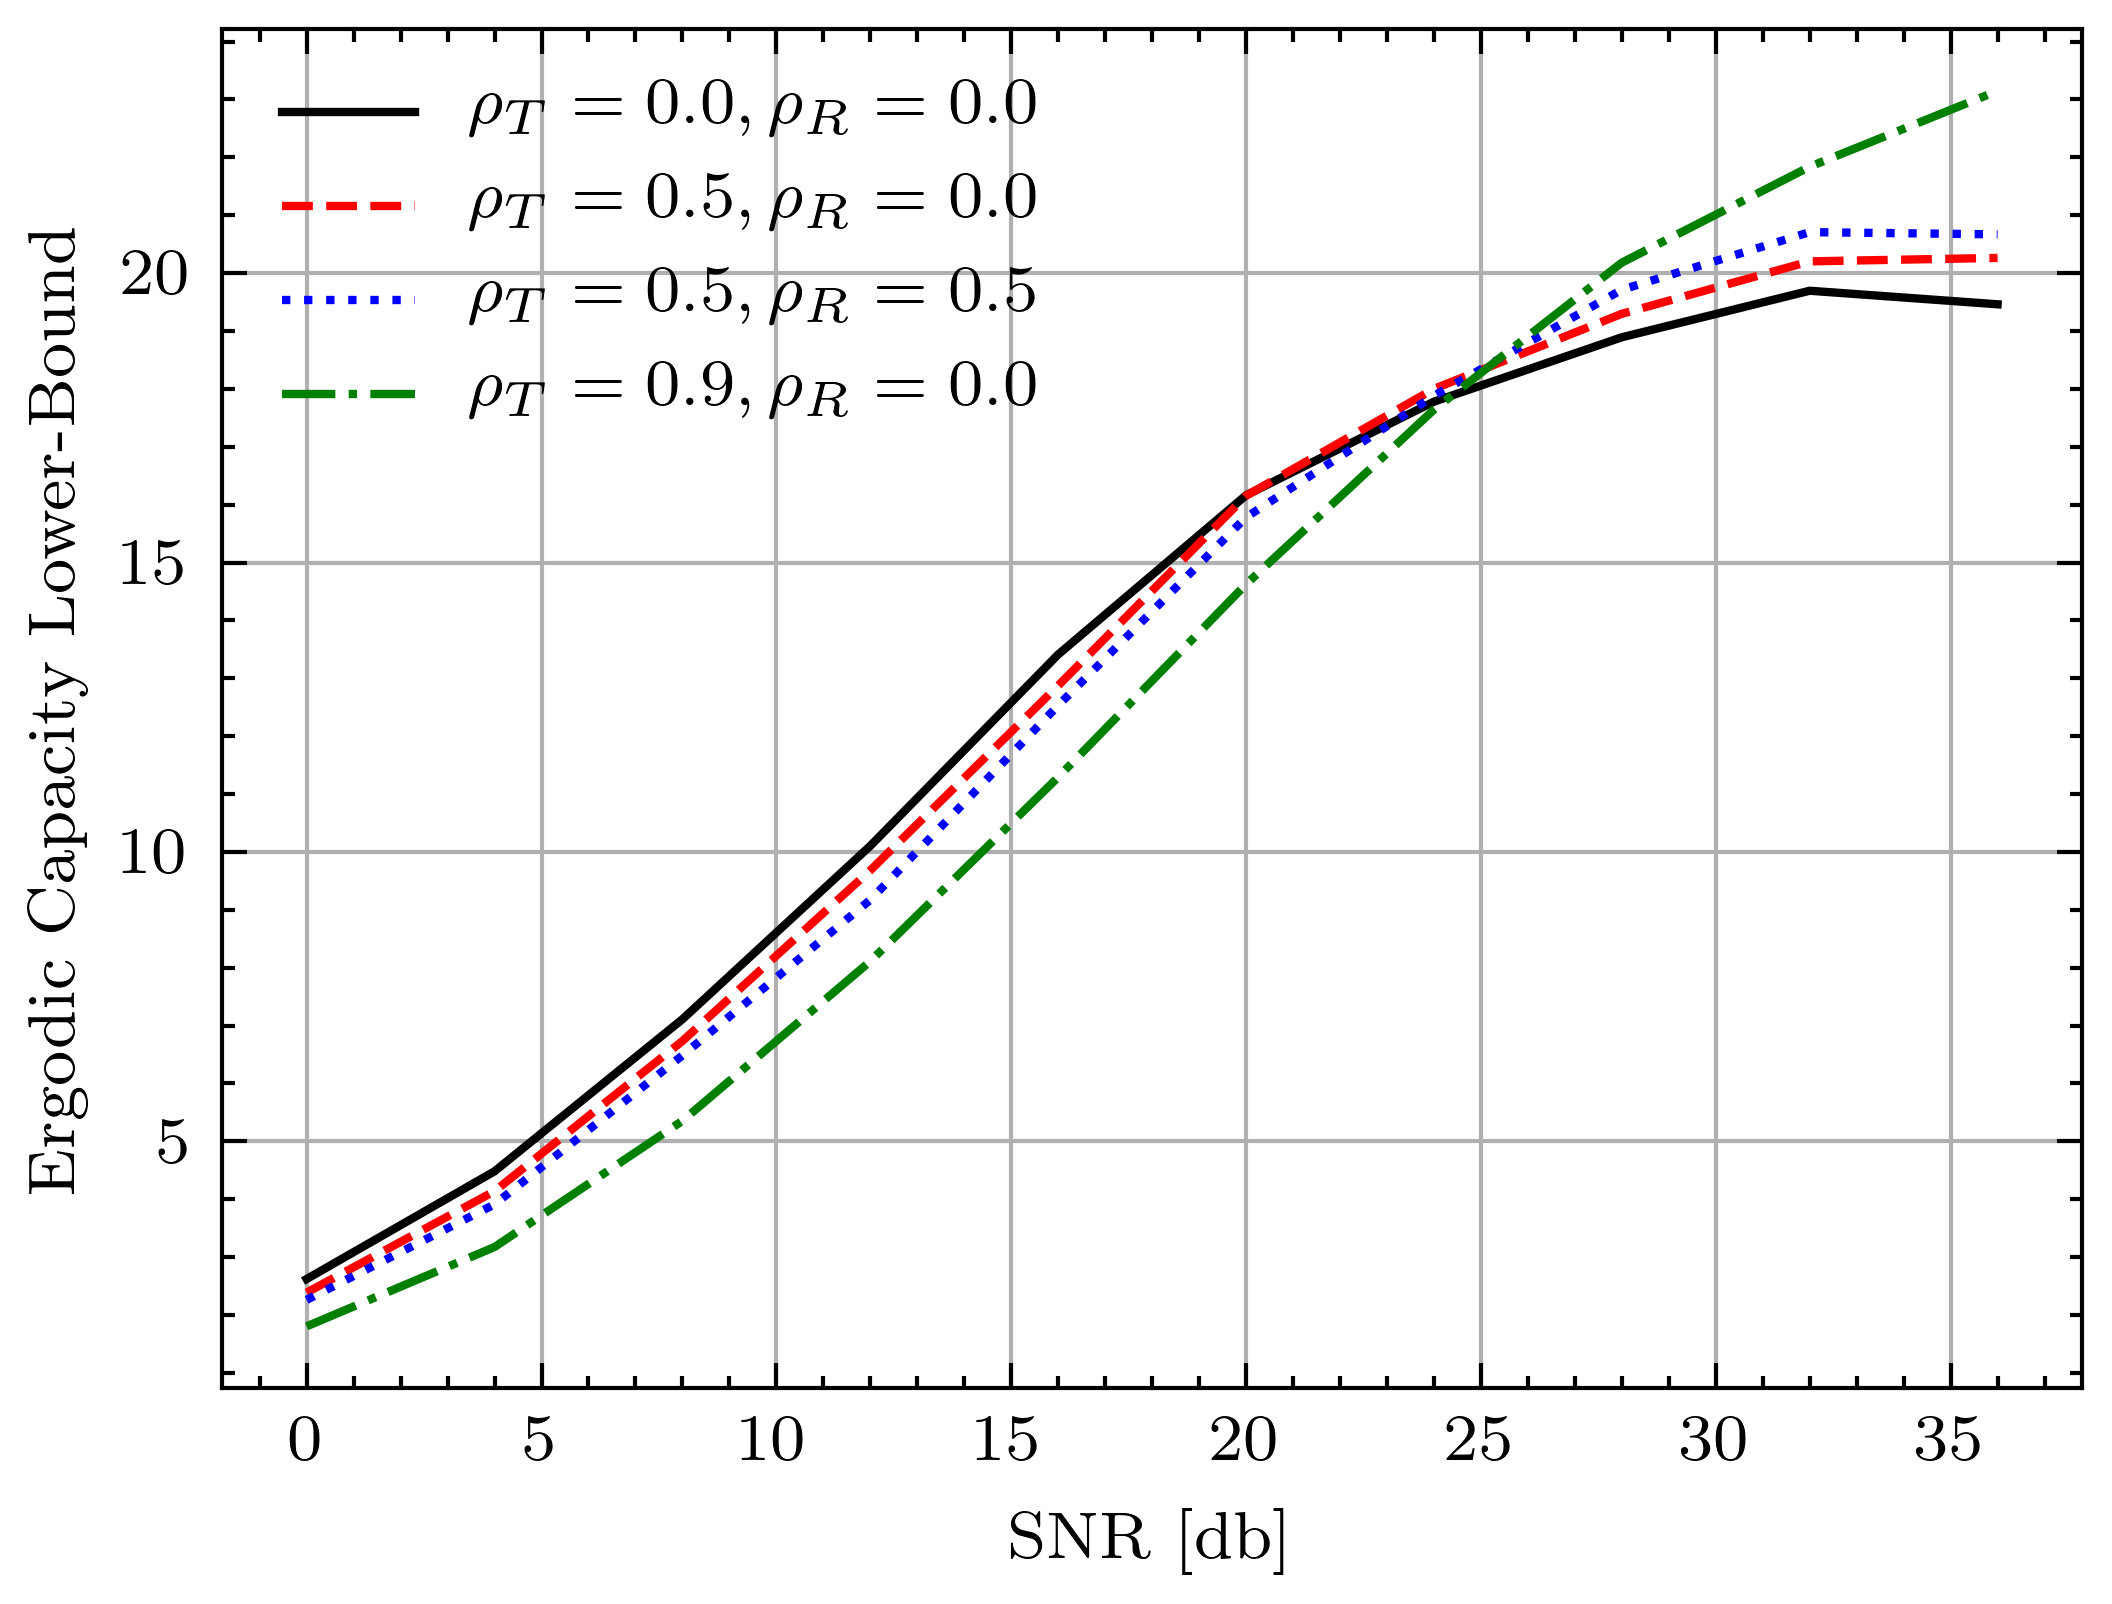

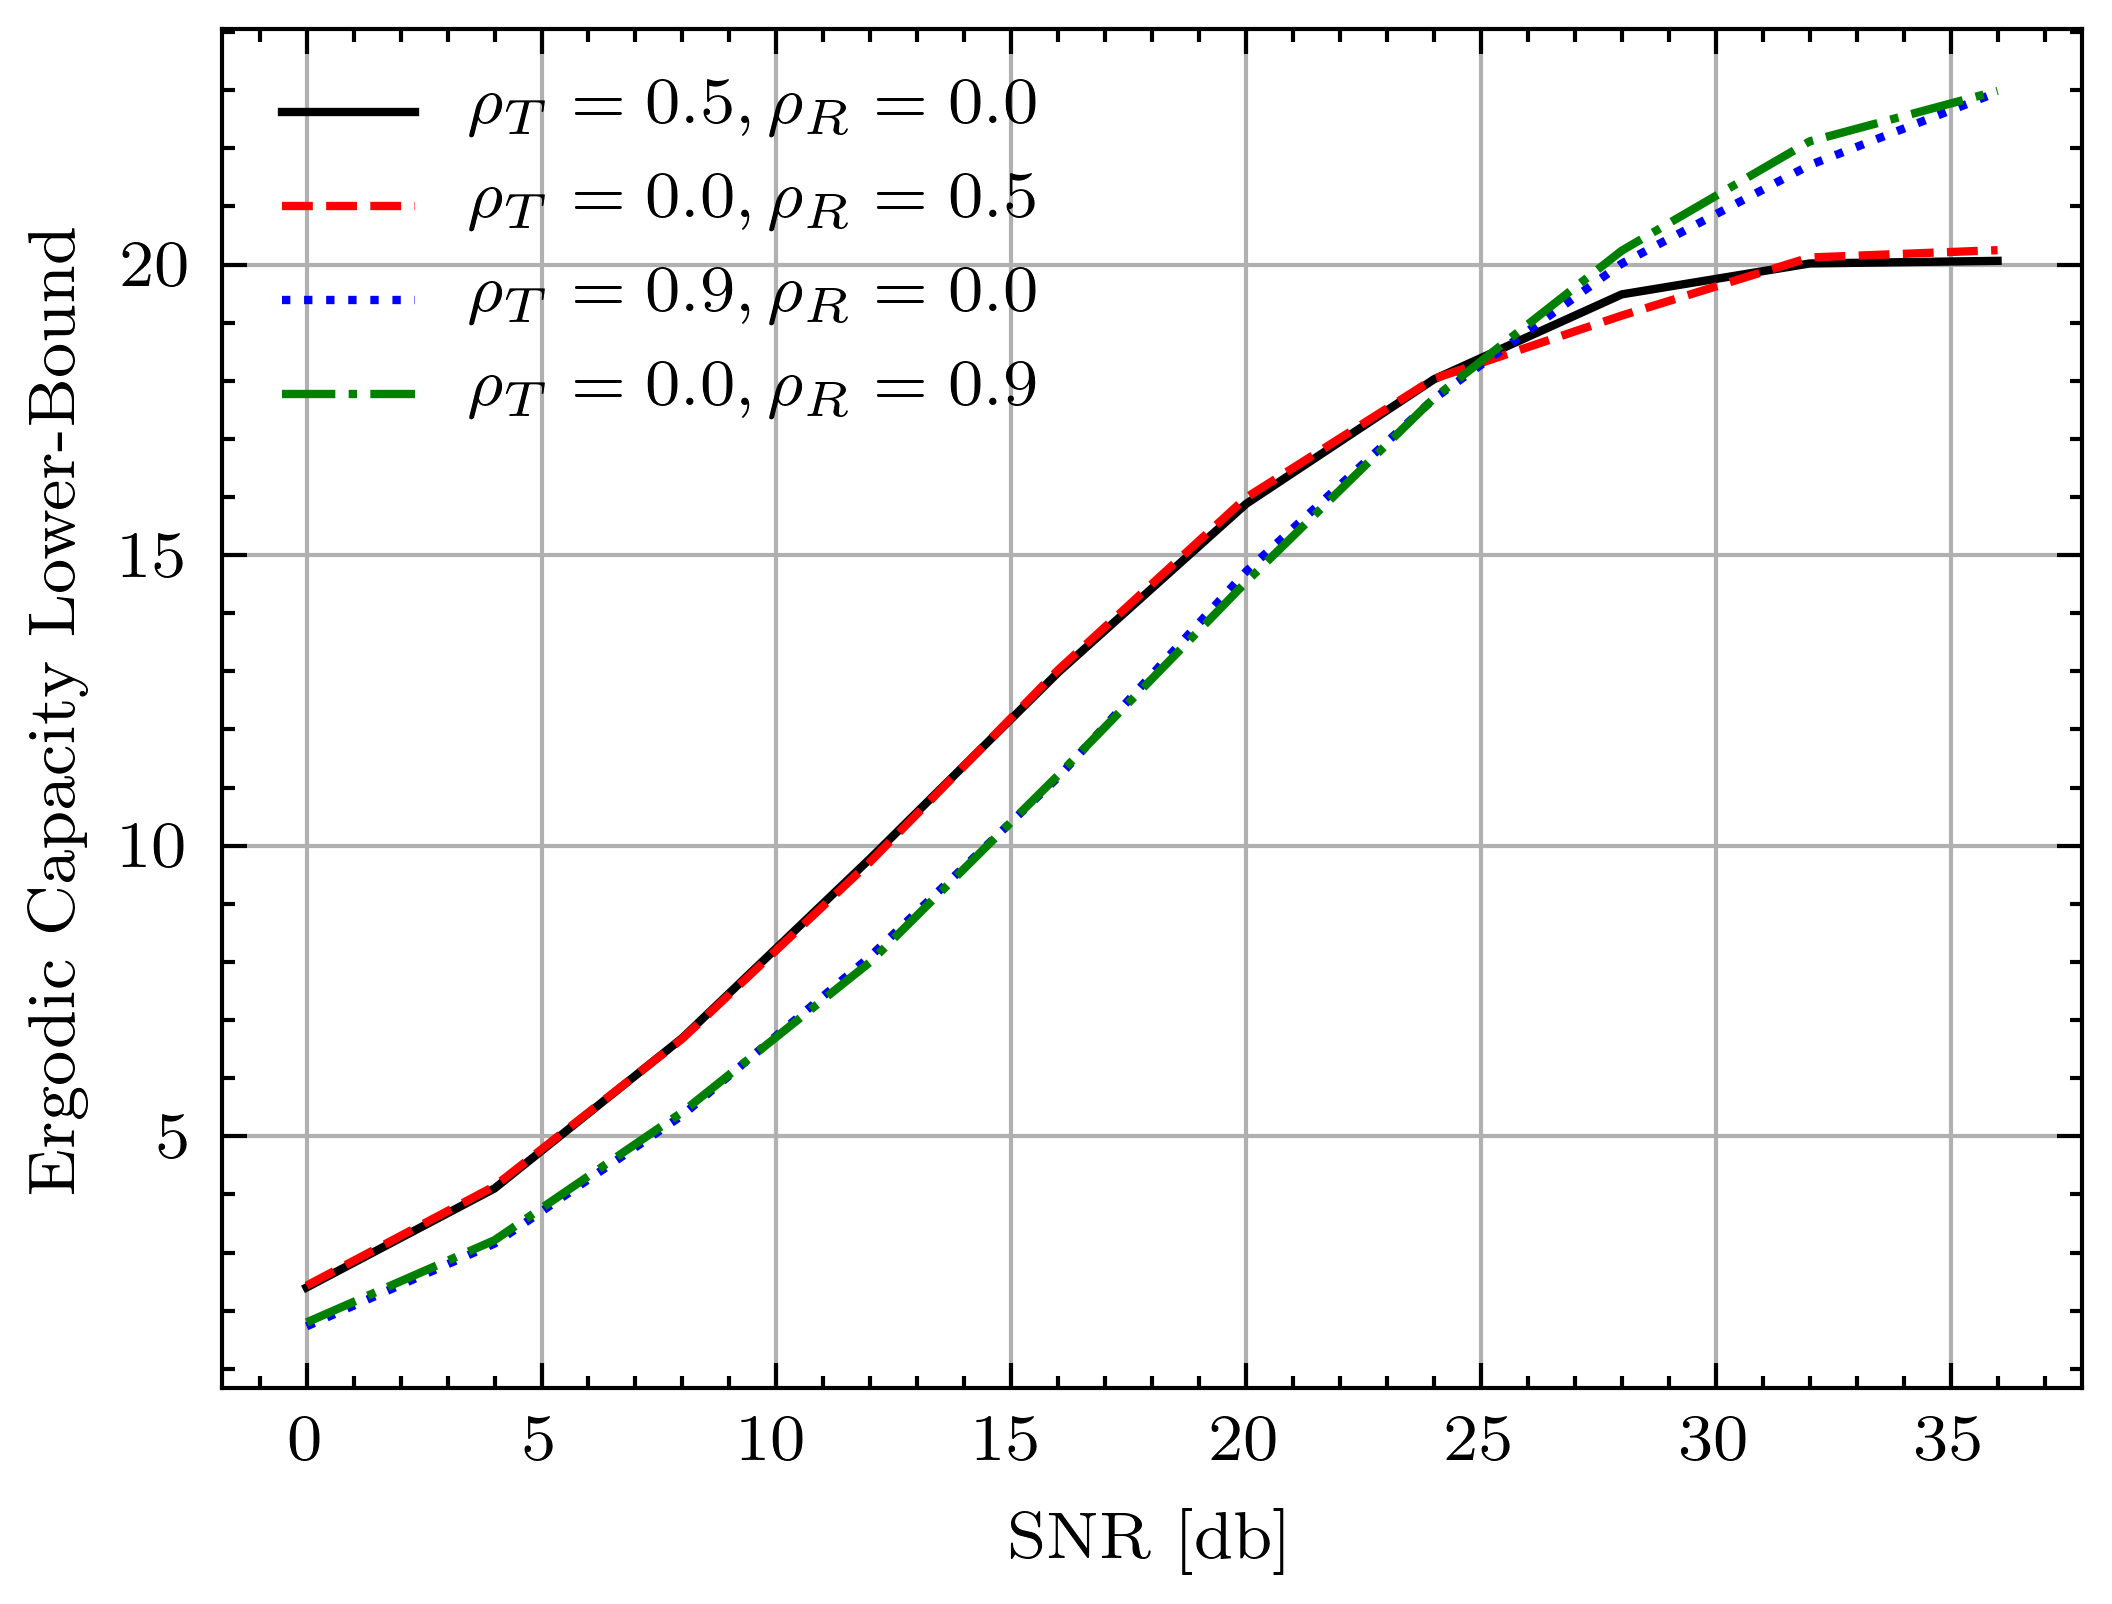

In [63]:
# Figure 3,4: plot capacity lower bounds for different correlation matrices
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(['science','ieee'])
# Data for plotting
# for fig3
fig3_labels = {
    0: r'$\rho_T=0.0,\rho_R=0.0$',
    1: r'$\rho_T=0.5,\rho_R=0.0$',
    2: r'$\rho_T=0.5,\rho_R=0.5$',
    3: r'$\rho_T=0.9,\rho_R=0.0$'
} 
# for fig4
fig4_labels = {
    0: r'$\rho_T=0.5,\rho_R=0.0$',
    1: r'$\rho_T=0.0,\rho_R=0.5$',
    2: r'$\rho_T=0.9,\rho_R=0.0$',
    3: r'$\rho_T=0.0,\rho_R=0.9$'
} 
labels_list = [fig3_labels,fig4_labels]
fig_names = ['fig3','fig4']
for j in range(2):
    fig, ax = plt.subplots(figsize=(4,3))
    cap_dict = cap_out_list[j]
    labels = labels_list[j]
    for i in range(4):
        ax.plot(snr_list, cap_dict[i],label=labels[i])
    ax.set(xlabel='SNR [db]', ylabel='Ergodic Capacity Lower-Bound')
    ax.grid()
    ax.legend()
    fig.savefig("figures/{}.png".format(fig_names[j]))
    plt.show()

In [131]:
# save results in json file
import json

data = {
    'snrs': snr_list,
    'data': fig4_cases
}
with open('fig4_data.json','w') as fp:
    json.dump(data, fp,sort_keys=True,indent=4)